# Membership Inference Attacks

Given a trained model and a datapoint, we can use membership inference attacks to determine if the datapoint was used to in the model's training data. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('default')


Let's create some more synthetic health data

In [2]:
def create_health_dataset(n_samples=2000):
    """Create a realistic health dataset for our attack"""
    np.random.seed(42)
    
    # Demographics
    age = np.random.normal(45, 15, n_samples)
    age = np.clip(age, 18, 90)
    
    bmi = np.random.normal(26, 4, n_samples)
    bmi = np.clip(bmi, 15, 45)
    
    # Risk factors (correlated with outcome)
    smoking = np.random.binomial(1, 0.3, n_samples)
    family_history = np.random.binomial(1, 0.4, n_samples)
    exercise_hours = np.random.exponential(2, n_samples)
    exercise_hours = np.clip(exercise_hours, 0, 10)
    
    # Create disease outcome (realistic correlations)
    risk_score = (
        0.05 * age + 
        0.1 * bmi + 
        2.0 * smoking + 
        1.5 * family_history - 
        0.3 * exercise_hours + 
        np.random.normal(0, 2, n_samples)
    )
    
    # Convert to probability and sample
    prob_disease = 1 / (1 + np.exp(-risk_score + 5))  # Logistic function
    has_disease = np.random.binomial(1, prob_disease, n_samples)
    
    return pd.DataFrame({
        'age': age,
        'bmi': bmi,
        'smoking': smoking,
        'family_history': family_history,
        'exercise_hours': exercise_hours,
        'has_disease': has_disease
    })



In [3]:
data = create_health_dataset(2000)

print(f"   • {len(data)} patient records")
print(f"   • {data['has_disease'].sum()} positive cases ({data['has_disease'].mean()*100:.1f}%)")
print(f"   • Features: {list(data.columns[:-1])}")
print()
print("Sample data:")
print(data.head())

   • 2000 patient records
   • 1102 positive cases (55.1%)
   • Features: ['age', 'bmi', 'smoking', 'family_history', 'exercise_hours']

Sample data:
         age        bmi  smoking  family_history  exercise_hours  has_disease
0  52.450712  23.299287        0               1        1.099370            0
1  42.926035  25.421925        0               0        1.456100            0
2  54.715328  22.830320        1               0        0.924067            1
3  67.845448  24.768154        0               0        2.700155            0
4  41.487699  18.425541        0               0        3.066688            0


In [4]:
# Split data
X = data.drop('has_disease', axis=1)
y = data['has_disease']

# Split into train/test (victim model will only see training data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

print(f"Data split:")
print(f"   • Training set: {len(X_train)} samples (victim model sees these)")
print(f"   • Test set: {len(X_test)} samples (victim model has NEVER seen these)")

# Train the victim model
print(f"\nTraining victim model (Random Forest)...")
victim_model = RandomForestClassifier(n_estimators=100, random_state=42)
victim_model.fit(X_train, y_train)

# Evaluate performance
train_acc = accuracy_score(y_train, victim_model.predict(X_train))
test_acc = accuracy_score(y_test, victim_model.predict(X_test))

print(f"   Training accuracy: {train_acc:.3f}")
print(f"   Test accuracy: {test_acc:.3f}")
print(f"   Model looks good! But does it leak membership info?")

Data split:
   • Training set: 1000 samples (victim model sees these)
   • Test set: 1000 samples (victim model has NEVER seen these)

Training victim model (Random Forest)...
   Training accuracy: 1.000
   Test accuracy: 0.642
   Model looks good! But does it leak membership info?


In [5]:
# Get prediction probabilities for both sets
train_probs = victim_model.predict_proba(X_train)
test_probs = victim_model.predict_proba(X_test)

# Extract confidence scores (max probability)
train_confidence = np.max(train_probs, axis=1)
test_confidence = np.max(test_probs, axis=1)

print(f"Confidence statistics:")
print(f"   Training data - Mean: {train_confidence.mean():.3f}, Std: {train_confidence.std():.3f}")
print(f"   Test data     - Mean: {test_confidence.mean():.3f}, Std: {test_confidence.std():.3f}")
print(f"   Difference: {train_confidence.mean() - test_confidence.mean():.3f}")


Confidence statistics:
   Training data - Mean: 0.851, Std: 0.094
   Test data     - Mean: 0.712, Std: 0.132
   Difference: 0.139


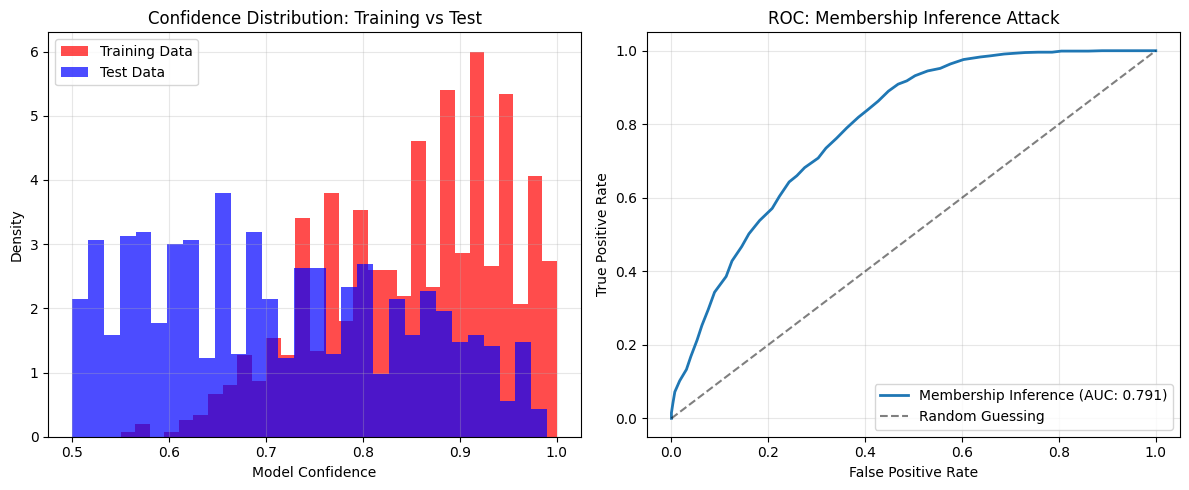

In [6]:
# Visualize the difference
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_confidence, bins=30, alpha=0.7, label='Training Data', color='red', density=True)
plt.hist(test_confidence, bins=30, alpha=0.7, label='Test Data', color='blue', density=True)
plt.xlabel('Model Confidence')
plt.ylabel('Density')
plt.title('Confidence Distribution: Training vs Test')
plt.legend()
plt.grid(True, alpha=0.3)

# ROC curve for membership inference
plt.subplot(1, 2, 2)
# Create labels: 1 for training data (member), 0 for test data (non-member)
membership_labels = np.concatenate([np.ones(len(train_confidence)), np.zeros(len(test_confidence))])
confidence_scores = np.concatenate([train_confidence, test_confidence])

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(membership_labels, confidence_scores)
auc_score = roc_auc_score(membership_labels, confidence_scores)

plt.plot(fpr, tpr, linewidth=2, label=f'Membership Inference (AUC: {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Membership Inference Attack')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
print(f"\nATTACK RESULTS:")
print(f"   • AUC Score: {auc_score:.3f} (0.5 = random, 1.0 = perfect attack)")
if auc_score > 0.6:
    print(f"   • SUCCESSFUL ATTACK! Model leaks membership information")
elif auc_score > 0.55:
    print(f"   • WEAK ATTACK: Some membership leakage detected")
else:
    print(f"   • Attack failed - model seems robust")



ATTACK RESULTS:
   • AUC Score: 0.791 (0.5 = random, 1.0 = perfect attack)
   • SUCCESSFUL ATTACK! Model leaks membership information


In [8]:
def create_shadow_data(original_data, n_shadow_models=5):
    """Create shadow datasets by sampling from the same distribution"""
    shadow_datasets = []
    
    for i in range(n_shadow_models):
        # Sample with replacement to create new datasets
        shadow_data = original_data.sample(n=len(original_data)//2, replace=True, random_state=i)
        shadow_datasets.append(shadow_data)
    
    return shadow_datasets

print(f"\nCreating shadow models...")
shadow_datasets = create_shadow_data(data, n_shadow_models=5)

# Train shadow models and collect attack training data
shadow_attack_features = []
shadow_attack_labels = []

for i, shadow_data in enumerate(shadow_datasets):
    print(f"   Training shadow model {i+1}/5...")
    
    # Split shadow data
    X_shadow = shadow_data.drop('has_disease', axis=1)
    y_shadow = shadow_data['has_disease']
    
    X_shadow_train, X_shadow_test, y_shadow_train, y_shadow_test = train_test_split(
        X_shadow, y_shadow, test_size=0.5, random_state=i, stratify=y_shadow
    )
    
    # Train shadow model
    shadow_model = RandomForestClassifier(n_estimators=50, random_state=i)
    shadow_model.fit(X_shadow_train, y_shadow_train)
    
    # Get predictions for attack training data
    train_probs_shadow = shadow_model.predict_proba(X_shadow_train)
    test_probs_shadow = shadow_model.predict_proba(X_shadow_test)
    
    # Create features for attack model (prediction probabilities)
    shadow_attack_features.extend(train_probs_shadow)  # These are members
    shadow_attack_features.extend(test_probs_shadow)   # These are non-members
    
    # Create labels (1 = member, 0 = non-member)
    shadow_attack_labels.extend([1] * len(train_probs_shadow))
    shadow_attack_labels.extend([0] * len(test_probs_shadow))

shadow_attack_features = np.array(shadow_attack_features)
shadow_attack_labels = np.array(shadow_attack_labels)

print(f"   Generated {len(shadow_attack_features)} attack training examples")



Creating shadow models...
   Training shadow model 1/5...
   Training shadow model 2/5...
   Training shadow model 3/5...
   Training shadow model 4/5...
   Training shadow model 5/5...
   Generated 5000 attack training examples


In [9]:
attack_model = LogisticRegression(random_state=42)
attack_model.fit(shadow_attack_features, shadow_attack_labels)

attack_train_acc = accuracy_score(shadow_attack_labels, attack_model.predict(shadow_attack_features))
print(f"   Attack model accuracy on shadow data: {attack_train_acc:.3f}")


   Attack model accuracy on shadow data: 0.514


In [10]:
# Get victim model predictions for attack
victim_train_probs = victim_model.predict_proba(X_train)
victim_test_probs = victim_model.predict_proba(X_test)

# Prepare attack data
attack_features = np.vstack([victim_train_probs, victim_test_probs])
attack_true_labels = np.concatenate([np.ones(len(victim_train_probs)), np.zeros(len(victim_test_probs))])

# Execute attack
attack_predictions = attack_model.predict_proba(attack_features)[:, 1]  # Probability of being a member
attack_binary = attack_model.predict(attack_features)

# Evaluate attack success
attack_accuracy = accuracy_score(attack_true_labels, attack_binary)
attack_auc = roc_auc_score(attack_true_labels, attack_predictions)

print(f"SHADOW MODEL ATTACK RESULTS:")
print(f"   • Attack Accuracy: {attack_accuracy:.3f}")
print(f"   • Attack AUC: {attack_auc:.3f}")
print(f"   • Improvement over simple method: {attack_auc - auc_score:.3f}")

if attack_auc > 0.7:
    print(f"   • HIGHLY SUCCESSFUL ATTACK!")
elif attack_auc > 0.6:
    print(f"   • SUCCESSFUL ATTACK")
else:
    print(f"   • Attack had limited success")

SHADOW MODEL ATTACK RESULTS:
   • Attack Accuracy: 0.530
   • Attack AUC: 0.521
   • Improvement over simple method: -0.270
   • Attack had limited success


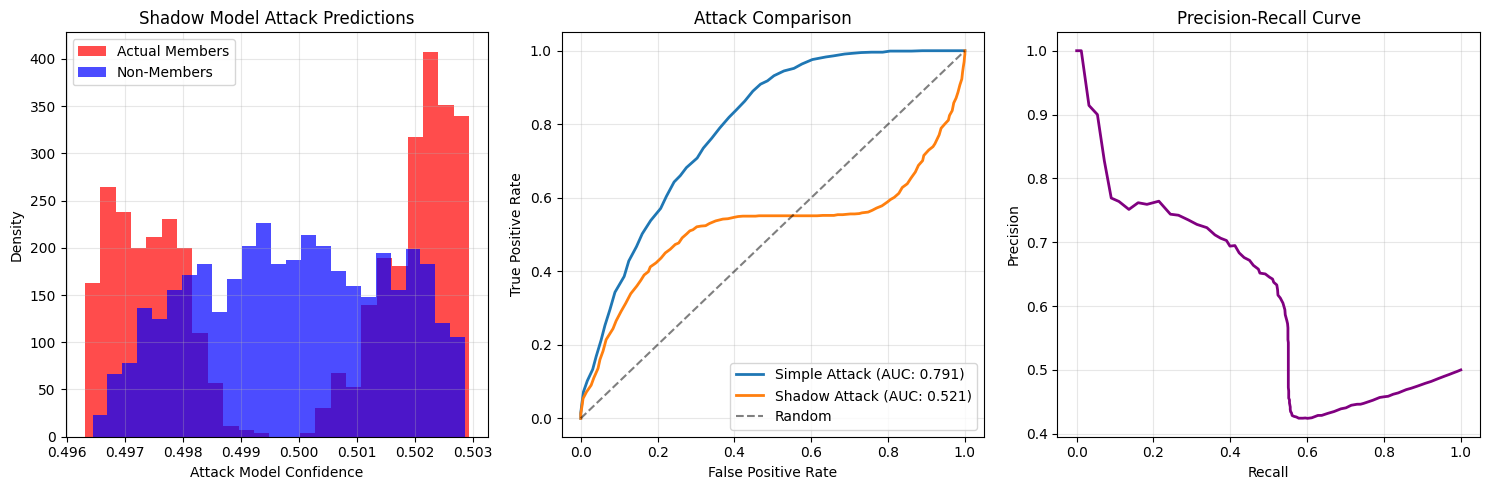

In [11]:
# Visualize attack results
plt.figure(figsize=(15, 5))

# Attack predictions by membership
plt.subplot(1, 3, 1)
member_scores = attack_predictions[attack_true_labels == 1]
non_member_scores = attack_predictions[attack_true_labels == 0]

plt.hist(member_scores, bins=25, alpha=0.7, label='Actual Members', color='red', density=True)
plt.hist(non_member_scores, bins=25, alpha=0.7, label='Non-Members', color='blue', density=True)
plt.xlabel('Attack Model Confidence')
plt.ylabel('Density')
plt.title('Shadow Model Attack Predictions')
plt.legend()
plt.grid(True, alpha=0.3)

# ROC curve comparison
plt.subplot(1, 3, 2)
fpr_simple, tpr_simple, _ = roc_curve(membership_labels, confidence_scores)
fpr_shadow, tpr_shadow, _ = roc_curve(attack_true_labels, attack_predictions)

plt.plot(fpr_simple, tpr_simple, linewidth=2, label=f'Simple Attack (AUC: {auc_score:.3f})')
plt.plot(fpr_shadow, tpr_shadow, linewidth=2, label=f'Shadow Attack (AUC: {attack_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Attack Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Precision-Recall curve
plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(attack_true_labels, attack_predictions)
plt.plot(recall, precision, linewidth=2, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
def evaluate_defense(X_train, X_test, y_train, y_test, model_params, defense_name):
    """Evaluate a defense against membership inference"""
    
    # Train defended model
    defended_model = RandomForestClassifier(**model_params)
    defended_model.fit(X_train, y_train)
    
    # Test model performance
    train_acc = accuracy_score(y_train, defended_model.predict(X_train))
    test_acc = accuracy_score(y_test, defended_model.predict(X_test))
    
    # Test membership inference vulnerability
    train_probs = defended_model.predict_proba(X_train)
    test_probs = defended_model.predict_proba(X_test)
    
    train_conf = np.max(train_probs, axis=1)
    test_conf = np.max(test_probs, axis=1)
    
    # Simple attack evaluation
    membership_labels = np.concatenate([np.ones(len(train_conf)), np.zeros(len(test_conf))])
    confidence_scores = np.concatenate([train_conf, test_conf])
    attack_auc = roc_auc_score(membership_labels, confidence_scores)
    
    return {
        'defense': defense_name,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'attack_auc': attack_auc,
        'utility_loss': test_acc - test_acc,  # Will compare to baseline
        'privacy_gain': 0  # Will compute relative to baseline
    }


In [13]:
# Baseline (no defense)
baseline = evaluate_defense(X_train, X_test, y_train, y_test, 
                          {'n_estimators': 100, 'random_state': 42}, 
                          'Baseline (No Defense)')

# Defense 1: Regularization (reduce overfitting)
regularized = evaluate_defense(X_train, X_test, y_train, y_test,
                             {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 10, 'random_state': 42},
                             'Regularization')

# Defense 2: Early stopping (fewer trees)
early_stop = evaluate_defense(X_train, X_test, y_train, y_test,
                            {'n_estimators': 20, 'random_state': 42},
                            'Early Stopping')

# Defense 3: Dropout (bootstrap sampling)
dropout = evaluate_defense(X_train, X_test, y_train, y_test,
                         {'n_estimators': 100, 'max_samples': 0.7, 'random_state': 42},
                         'Bootstrap Sampling')

results = [baseline, regularized, early_stop, dropout]

In [14]:
# Calculate relative metrics
baseline_auc = baseline['attack_auc']
baseline_acc = baseline['test_acc']

for result in results:
    result['privacy_gain'] = baseline_auc - result['attack_auc']
    result['utility_loss'] = baseline_acc - result['test_acc']

# Display results
print(f"\n📊 DEFENSE EVALUATION RESULTS:")
print(f"{'Defense':<20} {'Test Acc':<10} {'Attack AUC':<12} {'Privacy Gain':<13} {'Utility Loss'}")
print("=" * 80)

for result in results:
    print(f"{result['defense']:<20} {result['test_acc']:<10.3f} {result['attack_auc']:<12.3f} "
          f"{result['privacy_gain']:<13.3f} {result['utility_loss']:<10.3f}")

print(f"\nKEY INSIGHTS:")
print(f"   • Lower Attack AUC = Better Privacy (closer to 0.5)")
print(f"   • Higher Privacy Gain = More effective defense")
print(f"   • Lower Utility Loss = Better model performance")


📊 DEFENSE EVALUATION RESULTS:
Defense              Test Acc   Attack AUC   Privacy Gain  Utility Loss
Baseline (No Defense) 0.642      0.791        0.000         0.000     
Regularization       0.663      0.526        0.266         -0.021    
Early Stopping       0.632      0.748        0.043         0.010     
Bootstrap Sampling   0.649      0.712        0.079         -0.007    

KEY INSIGHTS:
   • Lower Attack AUC = Better Privacy (closer to 0.5)
   • Higher Privacy Gain = More effective defense
   • Lower Utility Loss = Better model performance


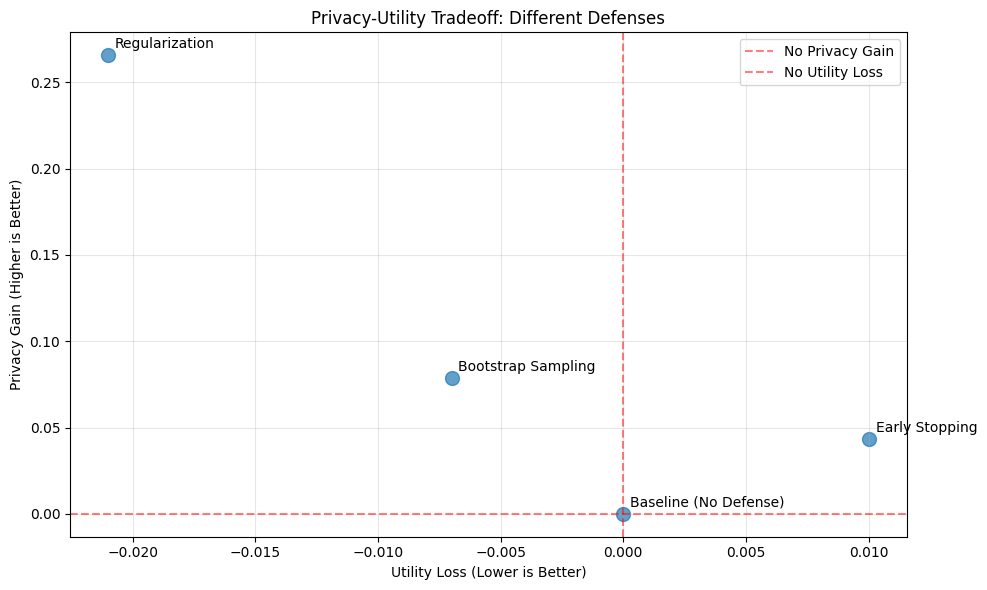

In [15]:
# Visualize tradeoffs
plt.figure(figsize=(10, 6))
defense_names = [r['defense'] for r in results]
privacy_gains = [r['privacy_gain'] for r in results]
utility_losses = [r['utility_loss'] for r in results]

plt.scatter(utility_losses, privacy_gains, s=100, alpha=0.7)
for i, name in enumerate(defense_names):
    plt.annotate(name, (utility_losses[i], privacy_gains[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)

plt.xlabel('Utility Loss (Lower is Better)')
plt.ylabel('Privacy Gain (Higher is Better)')
plt.title('Privacy-Utility Tradeoff: Different Defenses')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='No Privacy Gain')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='No Utility Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
def add_dp_noise_to_model(model, epsilon=1.0):
    """
    Simulate adding DP noise to model parameters
    This is a simplified version for educational purposes
    """
    # In real DP-SGD, noise is added to gradients during training
    # Here we'll add noise to final predictions as a proxy
    
    def dp_predict_proba(X):
        # Get original predictions
        original_probs = model.predict_proba(X)
        
        # Add noise proportional to privacy budget
        noise_scale = 0.1 / epsilon  # Simplified noise calculation
        noise = np.random.laplace(0, noise_scale, original_probs.shape)
        
        # Add noise and renormalize
        noisy_probs = original_probs + noise
        noisy_probs = np.clip(noisy_probs, 0.001, 0.999)  # Clip to valid probabilities
        
        # Renormalize to ensure probabilities sum to 1
        noisy_probs = noisy_probs / noisy_probs.sum(axis=1, keepdims=True)
        
        return noisy_probs
    
    # Monkey patch the model
    model.dp_predict_proba = dp_predict_proba
    return model

# Test different epsilon values
epsilons = [0.1, 0.5, 1.0, 5.0, 10.0]
dp_results = []

In [17]:
for epsilon in epsilons:
    # Create DP model
    dp_model = RandomForestClassifier(n_estimators=100, random_state=42)
    dp_model.fit(X_train, y_train)
    dp_model = add_dp_noise_to_model(dp_model, epsilon)
    
    # Evaluate utility
    test_probs_dp = dp_model.dp_predict_proba(X_test)
    test_pred_dp = np.argmax(test_probs_dp, axis=1)
    test_acc_dp = accuracy_score(y_test, test_pred_dp)
    
    # Evaluate privacy (membership inference resistance)
    train_probs_dp = dp_model.dp_predict_proba(X_train)
    train_conf_dp = np.max(train_probs_dp, axis=1)
    test_conf_dp = np.max(test_probs_dp, axis=1)
    
    membership_labels = np.concatenate([np.ones(len(train_conf_dp)), np.zeros(len(test_conf_dp))])
    confidence_scores = np.concatenate([train_conf_dp, test_conf_dp])
    attack_auc_dp = roc_auc_score(membership_labels, confidence_scores)
    
    dp_results.append({
        'epsilon': epsilon,
        'test_acc': test_acc_dp,
        'attack_auc': attack_auc_dp,
        'privacy_gain': baseline_auc - attack_auc_dp,
        'utility_loss': baseline_acc - test_acc_dp
    })
    
    print(f"   ε={epsilon:4.1f}: Acc={test_acc_dp:.3f}, Attack AUC={attack_auc_dp:.3f}")


   ε= 0.1: Acc=0.544, Attack AUC=0.498
   ε= 0.5: Acc=0.619, Attack AUC=0.639
   ε= 1.0: Acc=0.629, Attack AUC=0.719
   ε= 5.0: Acc=0.645, Attack AUC=0.781
   ε=10.0: Acc=0.645, Attack AUC=0.791


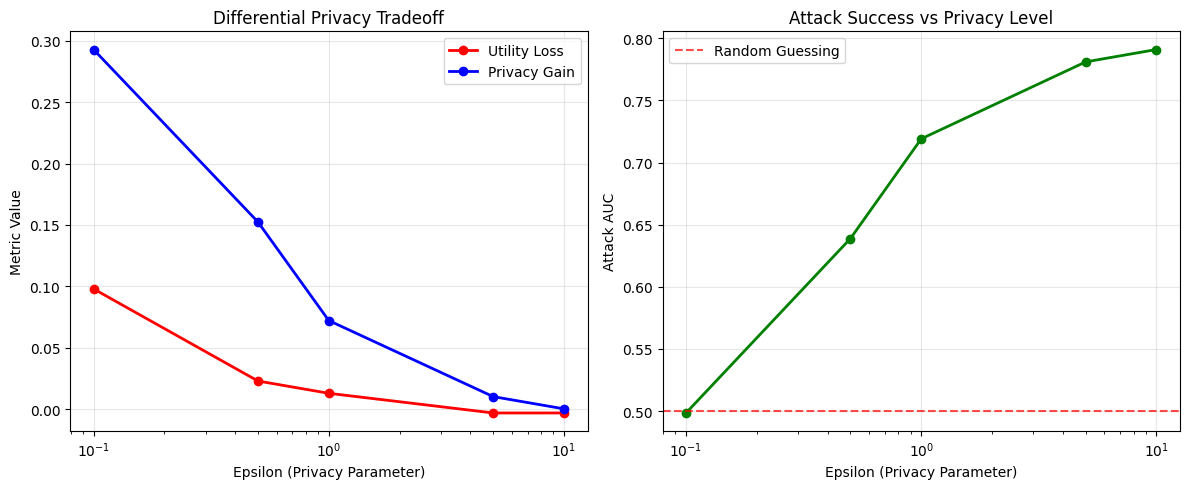

In [18]:
# Plot DP tradeoff
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
epsilons_plot = [r['epsilon'] for r in dp_results]
utility_losses = [r['utility_loss'] for r in dp_results]
privacy_gains = [r['privacy_gain'] for r in dp_results]

plt.plot(epsilons_plot, utility_losses, 'r-o', linewidth=2, label='Utility Loss')
plt.plot(epsilons_plot, privacy_gains, 'b-o', linewidth=2, label='Privacy Gain')
plt.xlabel('Epsilon (Privacy Parameter)')
plt.ylabel('Metric Value')
plt.title('Differential Privacy Tradeoff')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.subplot(1, 2, 2)
attack_aucs = [r['attack_auc'] for r in dp_results]
plt.plot(epsilons_plot, attack_aucs, 'g-o', linewidth=2)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random Guessing')
plt.xlabel('Epsilon (Privacy Parameter)')
plt.ylabel('Attack AUC')
plt.title('Attack Success vs Privacy Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.tight_layout()
plt.show()

### Exercises 

1. Attack Different Model Types
   * Try membership inference on Logistic Regression, SVM, or Neural Networks
   * Question: Which model types are most vulnerable?
<br></br>
2. Vary Dataset Properties
   * Create datasets with different sizes (100, 1000, 10000 samples)
   * Test attack success vs dataset size
   * Question: Are smaller datasets more vulnerable?
<br></br>
3. Design Your Own Defense
   * Implement a custom defense (e.g., prediction smoothing, ensemble voting)
   * Compare its privacy-utility tradeoff to existing defenses
   * Question: Can you beat regularization?
<br></br>
4. Multi-class Membership Inference
   * Extend the attack to datasets with more than 2 classes
   * Does attack success change with number of classes?
   * Question: How does class imbalance affect membership inference?
<br></br>
5. Stretch exercise: Realistic Attack Scenario
   * Assume you're an attacker with limited knowledge
   * You don't know the exact training data distribution
   * Can you still mount a successful membership inference attack?
   * Hint: Try using publicly available similar datasets for shadow models

### Discussion

1. In what scenarios would membership inference attacks be most dangerous?
2. How might federated learning change the attack landscape?
3. What ethical considerations arise when publishing models?
4. How should organizations balance model utility vs privacy risks?